# Club Mahindra DataOlympics 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error
import math
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [4]:
def binning(col, cut_points, labels=None):
  #Define min and max values:
    minval = col.min()
    maxval = col.max()

    #create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    #if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points)+1)

    #Binning using cut function of pandas
    colBin = pd.cut(col,bins=break_points,labels=labels,include_lowest=True)
    return colBin






In [5]:
train_df = pd.read_csv('train.csv',
                   parse_dates=[1,2,3], 
                    dayfirst=True)

In [6]:
train = train_df.copy()

In [7]:
train.head().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 24 columns):
reservation_id                        5 non-null object
booking_date                          5 non-null datetime64[ns]
checkin_date                          5 non-null datetime64[ns]
checkout_date                         5 non-null datetime64[ns]
channel_code                          5 non-null int64
main_product_code                     5 non-null int64
numberofadults                        5 non-null int64
numberofchildren                      5 non-null int64
persontravellingid                    5 non-null int64
resort_region_code                    5 non-null int64
resort_type_code                      5 non-null int64
room_type_booked_code                 5 non-null int64
roomnights                            5 non-null int64
season_holidayed_code                 5 non-null float64
state_code_residence                  5 non-null float64
state_code_resort                     5 no

In [8]:
train.shape

(341424, 24)

In [9]:
train.isna().sum()

reservation_id                           0
booking_date                             0
checkin_date                             0
checkout_date                            0
channel_code                             0
main_product_code                        0
numberofadults                           0
numberofchildren                         0
persontravellingid                       0
resort_region_code                       0
resort_type_code                         0
room_type_booked_code                    0
roomnights                               0
season_holidayed_code                  114
state_code_residence                  4764
state_code_resort                        0
total_pax                                0
member_age_buckets                       0
booking_type_code                        0
memberid                                 0
cluster_code                             0
reservationstatusid_code                 0
resort_id                                0
amount_spen

Since number of NA's arent that huge, using forward fill method 



In [10]:
train.state_code_residence.fillna(method = 'ffill',inplace =True)
train.season_holidayed_code.fillna(method = 'ffill',inplace= True)

In [11]:
train.state_code_residence.value_counts()

8.0     136762
2.0      41714
1.0      28408
7.0      26252
5.0      21263
4.0      16188
9.0      12501
15.0      9629
10.0      9521
6.0       6506
12.0      6173
3.0       4064
23.0      3893
14.0      3165
16.0      2395
13.0      1798
21.0      1717
20.0      1492
18.0      1445
19.0      1096
26.0      1076
25.0       852
27.0       820
11.0       719
28.0       555
22.0       436
24.0       385
30.0       146
29.0       103
33.0        91
31.0        60
37.0        59
32.0        57
34.0        48
35.0        17
36.0        12
38.0         6
Name: state_code_residence, dtype: int64

In [12]:
#working with checkin date
train['checkin_year'] = train['checkin_date'].dt.year
train['checkin_month'] = train['checkin_date'].dt.month
train['checkin_day'] = train['checkin_date'].dt.day
train['checkin_dow'] = train['checkin_date'].dt.dayofweek

In [13]:
train['checkin_year'].value_counts()

2017    87841
2018    83515
2016    82340
2015    75088
2019    12628
2012       12
Name: checkin_year, dtype: int64

In [14]:
#using checkin year as a category rather than a numerical feature
train['checkin_year'] = train['checkin_year'].astype('category')

In [15]:
train['checkin_month'].value_counts()

1     34110
5     30786
2     30167
4     30052
12    29822
3     28773
6     28479
10    27920
11    27230
7     25432
9     25026
8     23627
Name: checkin_month, dtype: int64

The competition was based about a club chain in India, hence I used the logic and data about various seasons that the indan subcontinent has

In [16]:

winter = [1,2,12]
summer = [5,6]
monsoon = [7,8,9]
post_monsoon = [10,11]
just_right = [3,4]

In [17]:
train['season'] = 0
train.loc[train['checkin_month'].isin(winter),'season'] = 'winter'
train.loc[train['checkin_month'].isin(summer),'season'] = 'summer'
train.loc[train['checkin_month'].isin(monsoon),'season'] = 'monsoon'
train.loc[train['checkin_month'].isin(post_monsoon),'season'] = 'post_monsoon'
train.loc[train['checkin_month'].isin(just_right),'season'] = 'just_right' #Perasonal choice and it didnt fit well with other categories


In [18]:
train['season'] = train['season'].astype('category')

In [19]:
train.season.value_counts()

winter          94099
monsoon         74085
summer          59265
just_right      58825
post_monsoon    55150
Name: season, dtype: int64

In [20]:
train['checkin_dow'].value_counts()
#0 is monday


4    56621
6    53425
5    52000
0    47723
3    45002
1    43348
2    43305
Name: checkin_dow, dtype: int64

Since people usually travel on weekends i divided the data based on that

In [21]:
weekday = [5,6,7] 

In [22]:
train['weekend'] = 0
train.loc[train['checkin_dow'].isin(weekday),'weekend'] = 1

In [23]:
train['weekend'].value_counts()

0    235999
1    105425
Name: weekend, dtype: int64

I wanted to check the logic weather people showed a difference in spending based on the time of the month they travel in considering india has first week payment each month

In [24]:

start = list(range(1,16))
end = list(range(15,32))

In [25]:
train['time_of_month']=0
train.loc[train['checkin_day'].isin(end),'time_of_month'] = 1


In [26]:
train['time_of_month'].value_counts()

1    185884
0    155540
Name: time_of_month, dtype: int64

In [27]:
train.channel_code.value_counts()

1    161225
3    128042
2     52157
Name: channel_code, dtype: int64

In [28]:
train['channel_code'] = train['channel_code'].astype('category')

How long ago did the customer book their travel? 

In [29]:
train['diff1'] =  train.booking_date-train.checkin_date
train['diff1'] = train['diff1'].astype(str)
train['diff1'] = train['diff1'].str.split(' ').str[0]
train['diff1'] = train['diff1'].astype('int') * -1

There were a few dates where checkin year is 2012 and booking is 2018 (Which was maybe filled by the club where they didnt have booking date information)
Converting those valeus to 0

In [30]:
train.loc[(train['diff1']<0),'diff1'] = 0

Looking at the histogram it is clear people tend to book closer to their visiting dates

(array([64594., 83565., 33810., 26721., 19596., 18533., 20260., 34581.,
        29515., 10249.]),
 array([  0. ,  12.6,  25.2,  37.8,  50.4,  63. ,  75.6,  88.2, 100.8,
        113.4, 126. ]),
 <a list of 10 Patch objects>)

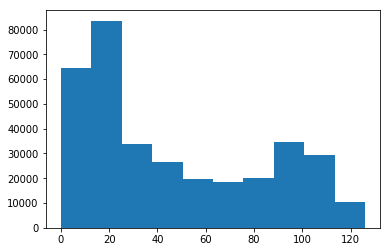

In [31]:
plt.hist(train.diff1)

Total amounts of days the customer spent in the club

In [32]:
train['checkin_checkout'] = train.checkout_date-train.checkin_date
train['checkin_checkout'] = train['checkin_checkout'].astype(str)
train['checkin_checkout']= train['checkin_checkout'].str.split(' ').str[0]
train['checkin_checkout'] = train['checkin_checkout'].astype(int)

(array([1.84552e+05, 1.43073e+05, 9.50900e+03, 4.07900e+03, 1.65000e+02,
        2.70000e+01, 1.00000e+01, 7.00000e+00, 0.00000e+00, 0.00000e+00,
        0.00000e+00, 0.00000e+00, 1.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 1.        ,  2.66666667,  4.33333333,  6.        ,  7.66666667,
         9.33333333, 11.        , 12.66666667, 14.33333333, 16.        ,
        17.66666667, 19.33333333, 21.        , 22.66666667, 24.33333333,
        26.        ]),
 <a list of 15 Patch objects>)

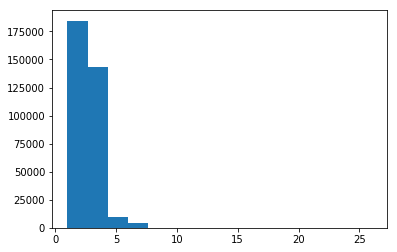

In [33]:
plt.hist(train['checkin_checkout'], bins = 15 )

In [34]:
train.main_product_code.value_counts()

2    177615
3     86247
1     57822
4     18619
7      1121
Name: main_product_code, dtype: int64

In [35]:
train['main_product_code'] = train['main_product_code'].astype('category')

In [36]:
train.numberofadults.value_counts()

2     149414
4      84468
3      63247
6      20052
5       9849
8       5198
7       2673
9       1445
1       1280
10      1256
12      1010
11       357
16       293
14       216
15       207
13       120
24        83
20        64
18        62
0         27
17        20
22        19
19        12
25        12
21        11
23        10
32        10
30         9
Name: numberofadults, dtype: int64

In [37]:
#Binning Number of adults:
cut_points = [2,3,4,6,10,20]
labels = ["Under2","Under3","Under4",'Under6','Under10','Under20','Above20']
train['numberofadults_bins'] = binning(train["numberofadults"], cut_points, labels)
train['numberofadults_bins'] =train['numberofadults_bins'].astype('category')




In [38]:
train.numberofchildren.value_counts()

0     264250
1      37766
2      35164
3       2137
4       1658
6        187
5        181
8         44
7         20
10        14
12         2
13         1
Name: numberofchildren, dtype: int64

In [39]:
#Binning Number of children:
cut_points = [0.9,1,2,4]
labels = ["None","Under1",'Under2',"Under4",'Above7']
train['numberofchildren_bins'] = binning(train["numberofchildren"], cut_points, labels)
train['numberofchildren_bins'] =train['numberofchildren_bins'].astype('category')





In [40]:
train.persontravellingid.value_counts()

45      267307
47       31580
46       30569
4752     10556
4753      1391
4995        21
Name: persontravellingid, dtype: int64

In [41]:
 train['persontravellingid'] = train['persontravellingid'].astype('category')

In [42]:
train.resort_region_code.value_counts()

1    143790
2    131361
3     66273
Name: resort_region_code, dtype: int64

In [43]:
 train['resort_region_code'] = train['resort_region_code'].astype('category')

In [44]:
train.resort_type_code.value_counts()

1    154324
2     74154
3     48681
5     26706
4     21619
7     11478
0      4462
Name: resort_type_code, dtype: int64

In [45]:
 train['resort_type_code'] = train['resort_type_code'].astype('category')

In [46]:
train.room_type_booked_code.value_counts()

3    137439
2    113459
4     83554
1      5374
5      1588
6        10
Name: room_type_booked_code, dtype: int64

In [47]:
train['room_type_booked_code'] = train['room_type_booked_code'].astype('category')

In [48]:
train.roomnights.value_counts()

 3     94256
 2     85105
 4     58487
 6     36932
 1     25777
 5     12303
 8     10716
 9      5107
 12     3546
 10     2912
 7      2883
 15      805
 16      592
 14      496
 11      322
 18      312
 20      215
 13      119
 21       93
 24       89
 17       59
 30       57
 28       50
 27       27
 19       27
 23       19
 22       15
 25       15
 36       12
 31       12
 26       11
 32        9
 35        8
 47        6
 29        5
 34        5
 37        5
 39        5
 42        4
 33        2
-45        1
 60        1
 41        1
 0         1
Name: roomnights, dtype: int64

In [49]:
#Binning Number of nights spent:
cut_points = [1,2,3,4,5,6,8,10,15,20]
labels = ["onenight","twonights",'threenights',"fournights",'fivenights','sixnights'
          ,'lessthan8','lessthan10','lessthan15','lessthan20','morethan20']
train['nights_bin'] = binning(train["roomnights"], cut_points, labels)
train['nights_bin'] =train['nights_bin'].astype('category')

In [50]:
train.season_holidayed_code.value_counts()



2.0    126822
3.0    118217
4.0     69399
1.0     26986
Name: season_holidayed_code, dtype: int64

In [51]:
train['season_holidayed_code'] = train['season_holidayed_code'].astype('category')

In [52]:
train.state_code_residence.value_counts()
# look into frequency binning

8.0     136762
2.0      41714
1.0      28408
7.0      26252
5.0      21263
4.0      16188
9.0      12501
15.0      9629
10.0      9521
6.0       6506
12.0      6173
3.0       4064
23.0      3893
14.0      3165
16.0      2395
13.0      1798
21.0      1717
20.0      1492
18.0      1445
19.0      1096
26.0      1076
25.0       852
27.0       820
11.0       719
28.0       555
22.0       436
24.0       385
30.0       146
29.0       103
33.0        91
31.0        60
37.0        59
32.0        57
34.0        48
35.0        17
36.0        12
38.0         6
Name: state_code_residence, dtype: int64

In [53]:
train['state_code_residence'] = train['state_code_residence'].astype('category')

In [54]:
train.columns

Index(['reservation_id', 'booking_date', 'checkin_date', 'checkout_date',
       'channel_code', 'main_product_code', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'resort_region_code',
       'resort_type_code', 'room_type_booked_code', 'roomnights',
       'season_holidayed_code', 'state_code_residence', 'state_code_resort',
       'total_pax', 'member_age_buckets', 'booking_type_code', 'memberid',
       'cluster_code', 'reservationstatusid_code', 'resort_id',
       'amount_spent_per_room_night_scaled', 'checkin_year', 'checkin_month',
       'checkin_day', 'checkin_dow', 'season', 'weekend', 'time_of_month',
       'diff1', 'checkin_checkout', 'numberofadults_bins',
       'numberofchildren_bins', 'nights_bin'],
      dtype='object')

In [55]:
train.state_code_resort.value_counts()

1     59830
2     55883
6     50869
7     37809
3     33489
5     32784
9     28115
11    18271
4     14820
10     5684
13     3870
Name: state_code_resort, dtype: int64

In [56]:
train['state_code_resort'] = train['state_code_resort'].astype('category')

In [57]:
train.total_pax.value_counts()

2     106046
3      98504
4      97386
5      20672
6       8350
1       5912
7       3102
8       1093
9        229
10        74
11        18
0         16
12        13
21         3
13         2
20         2
14         1
24         1
Name: total_pax, dtype: int64

In [58]:
#Binning age:
cut_points = [2,3,4,5,8]
labels = ["Under2","Under3",'Under4',"Under5","Under8",'Above8']
train['total_bins'] = binning(train["total_pax"], cut_points, labels)
train['total_bins'] =train['total_bins'].astype('category')






In [59]:
train.member_age_buckets.value_counts()

D    67618
E    66701
F    50967
C    45192
H    38548
G    36082
B    19430
I     8454
A     7054
J     1378
Name: member_age_buckets, dtype: int64

In [60]:
train['member_age_buckets'] = train['member_age_buckets'].astype('category')

In [61]:
train.booking_type_code.value_counts()

1    299016
2     42408
Name: booking_type_code, dtype: int64

In [62]:
train.loc[train['booking_type_code']==2,'booking_type_code'] = 0

In [63]:
train.drop('memberid',axis=1,inplace =True)
train.drop('reservation_id',axis=1,inplace =True)

In [64]:
train.cluster_code.value_counts()

F    120623
E     59830
D     55883
C     37809
B     37669
A     29610
Name: cluster_code, dtype: int64

In [65]:
train['cluster_code'] = train['cluster_code'].astype('category')

In [66]:
train.reservationstatusid_code.value_counts()

A    312481
B     14811
C     14131
D         1
Name: reservationstatusid_code, dtype: int64

In [67]:
train.booking_type_code.unique()

array([1, 0])

In [68]:
#Only 1 'D' in the train set provided and none in the. test set, converting that to the most common 
train.loc[train['reservationstatusid_code']=='D','reservationstatusid_code'] = 'A'

In [69]:
train['reservationstatusid_code'] = train['reservationstatusid_code'].astype('category')

In [70]:
train.resort_id.value_counts()

d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f90da3a666eec13ab35    35331
b17ef6d19c7a5b1ee83b907c595526dcb1eb06db8227d650d5dda0a9f4ce8cd9    28864
9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767    22344
49d180ecf56132819571bf39d9b7b342522a2ac6d23c1418d3338251bfe469c8    22005
6208ef0f7750c111548cf90b6ea1d0d0a66f6bff40dbef07cb45ec436263c7d6    19001
6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d49c01e52ddb7875b4b    18780
e29c9c180c6279b0b02abd6a1801c7c04082cf486ec027aa13515e4f3884bb6b    18271
da4ea2a5506f2693eae190d9360a1f31793c98a1adade51d93533a6f520ace1c    15465
624b60c58c9d8bfb6ff1886c2fd605d2adeb6ea4da576068201b6c6958ce93f4    12175
e7f6c011776e8db7cd330b54174fd76f7d0216b612387a5ffcfb81e6f0919683    12074
4ec9599fc203d176a301536c2e091a19bc852759b255bd6818810a42c5fed14a    12065
ff5a1ae012afa5d4c889c50ad427aaf545d31a4fac04ffc1c4d03d403ba4250a    11478
c75cb66ae28d8ebc6eded002c28a8ba0d06d3a78c6b5cbf9b2ade051f0775ac4    10621
535fa30d7e25dd8a49f1536779734ec8286108

In [71]:
train['resort_id'] = train['resort_id'].astype('category')

In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341424 entries, 0 to 341423
Data columns (total 35 columns):
booking_date                          341424 non-null datetime64[ns]
checkin_date                          341424 non-null datetime64[ns]
checkout_date                         341424 non-null datetime64[ns]
channel_code                          341424 non-null category
main_product_code                     341424 non-null category
numberofadults                        341424 non-null int64
numberofchildren                      341424 non-null int64
persontravellingid                    341424 non-null category
resort_region_code                    341424 non-null category
resort_type_code                      341424 non-null category
room_type_booked_code                 341424 non-null category
roomnights                            341424 non-null int64
season_holidayed_code                 341424 non-null category
state_code_residence                  341424 non-null categor

In [73]:
train1 = train.sample(frac=0.3, replace=False, random_state=1)

In [74]:
predictor = ['channel_code'
             ,'total_bins'
             ,'checkin_checkout'
             ,'numberofadults_bins'
             ,'numberofchildren_bins'
            ,'main_product_code'
            ,'persontravellingid'
            ,'resort_region_code'
            ,'resort_type_code'
            ,'room_type_booked_code'
            #,'roomnights'
            ,'season_holidayed_code'
            ,'state_code_residence'
            ,'state_code_resort'
            ,'member_age_buckets'
            ,'booking_type_code'
            ,'cluster_code'
            ,'reservationstatusid_code'
            ,'resort_id'
            ,'checkin_year'
            ,'season'
            ,'weekend'
            ,'time_of_month'
             , 'nights_bin'
            ,'diff1']



df = train1[predictor]
y = train1['amount_spent_per_room_night_scaled']



In [75]:
df.checkin_checkout = df.checkin_checkout.astype(int)
df.diff1 = df.diff1.astype(int)

/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 102427 entries, 209808 to 64165
Data columns (total 24 columns):
channel_code                102427 non-null category
total_bins                  102427 non-null category
checkin_checkout            102427 non-null int64
numberofadults_bins         102427 non-null category
numberofchildren_bins       102427 non-null category
main_product_code           102427 non-null category
persontravellingid          102427 non-null category
resort_region_code          102427 non-null category
resort_type_code            102427 non-null category
room_type_booked_code       102427 non-null category
season_holidayed_code       102427 non-null category
state_code_residence        102427 non-null category
state_code_resort           102427 non-null category
member_age_buckets          102427 non-null category
booking_type_code           102427 non-null int64
cluster_code                102427 non-null category
reservationstatusid_code    102427 non-null

In [77]:
cat_columns =  ['channel_code'
             ,'total_bins'
             ,'numberofadults_bins'
             ,'numberofchildren_bins'
            ,'main_product_code'
            ,'persontravellingid'
            ,'resort_region_code'
            ,'resort_type_code'
            ,'room_type_booked_code'
            ,'season_holidayed_code'
            ,'state_code_residence'
            ,'state_code_resort'
            ,'member_age_buckets'
            ,'cluster_code'
            ,'reservationstatusid_code'
            ,'resort_id'
            ,'checkin_year'
            ,'nights_bin'
            ,'season']



In [78]:
df = pd.get_dummies(df, drop_first=False, columns = cat_columns)

In [79]:
len(df.columns)

178

In [80]:
from sklearn.ensemble import RandomForestRegressor

In [81]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.10, random_state=42)
X_train = X_train.values
y_train = y_train.values.reshape(-1,)

In [82]:
rf = RandomForestRegressor(max_depth = 25
                           ,n_estimators=500
                          ,max_features = 0.8
                          ,min_samples_leaf =50
                          ,min_samples_split=100
                          ,n_jobs=4)

In [83]:
rf.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=50, min_samples_split=100,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [84]:
math.sqrt(mean_squared_error(rf.predict(X_test.values),y_test))

1.007407044137323

In [85]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X_test.columns, rf.feature_importances_):
    feats[feature] = importance #add the name/value pair 
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
#importances.sort_values(by='Gini-importance',ascending=False)
importances[importances['Gini-importance']>0.001].sort_values(by='Gini-importance',ascending=False)



,Gini-importance
checkin_checkout,0.261011
numberofadults_bins_Under2,0.081811
total_bins_Under2,0.074968
diff1,0.054435
persontravellingid_47,0.033635
nights_bin_twonights,0.029284
nights_bin_onenight,0.026920
resort_id_9400f1b21cb527d7fa3d3eabba93557a18ebe7a2ca4e471cfe5e4c5b4ca7f767,0.018068
numberofadults_bins_Under3,0.016767
state_code_resort_4,0.016246


In [86]:
to_keep = importances[importances['Gini-importance']>0.0005].index
df_keep = df[to_keep]

In [87]:
len(to_keep)

105

In [88]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.10, random_state=42)
X_train = X_train.values
y_train = y_train.values.reshape(-1,)

In [89]:
rf1 = RandomForestRegressor(max_depth = 10
                           ,n_estimators=500
                          ,max_features = 0.8
                          ,min_samples_leaf =10
                          ,min_samples_split=10
                          ,n_jobs=4)

In [90]:
rf1.fit(X_train,y_train)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features=0.8, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [91]:
pred = rf1.predict(X_test)
math.sqrt(mean_squared_error(pred,y_test))

1.0124712548635089

In [92]:
math.sqrt(mean_squared_error(rf1.predict(X_train),y_train))

0.9713759776819726

In [93]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.05, random_state=42)
X_train = X_train.values
y_train = y_train.values.reshape(-1,)
xgb1 = XGBRegressor(n_jobs=4
                  , n_estimators=100
                  , learning_rate=0.1
                  ,max_depth = 5
                   , objective='reg:linear'
                   ,booster = 'gbtree'
                   , subsample = 0.8
                   ,colsample_bylevel=0.8
                   ,colsample_bytree=1
                   ,reg_alpha=0.5
                   ,reg_lambda =1
                  )
xgb1.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=4,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [94]:
pred1 = xgb1.predict(X_test.values)
math.sqrt(mean_squared_error(pred1,y_test))

0.9827907067702937

Since XGBoost is performing better than random forest, using cross validation on XGboost

In [95]:
parameter_candidates = [
  {'max_depth': [3,5,8]
   ,'colsample_bylevel': [0.5,0.8]
   ,'colsample_bytree': [0.5,0.8]
   ,'reg_alpha': [0,0.5,1]
    ,'reg_lambda':[0,0.5,1]
  }
]

In [96]:
clf = GridSearchCV(estimator=XGBRegressor(n_jobs=-1
                  , n_estimators=100
                  , learning_rate=0.1, objective='reg:linear'
                   ,booster = 'gbtree'), cv = KFold(n_splits=10,shuffle=True),
                   param_grid=parameter_candidates, n_jobs=4)

In [97]:
clf.fit(X_train,y_train)

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=True),
       error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=4,
       param_grid=[{'max_depth': [3, 5, 8], 'colsample_bylevel': [0.5, 0.8], 'colsample_bytree': [0.5, 0.8], 'reg_alpha': [0, 0.5, 1], 'reg_lambda': [0, 0.5, 1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [98]:
clf.best_params_

{'colsample_bylevel': 0.8,
 'colsample_bytree': 0.8,
 'max_depth': 5,
 'reg_alpha': 1,
 'reg_lambda': 1}

In [105]:
X_train, X_test, y_train, y_test = train_test_split(df_keep, y, test_size=0.05, random_state=42)
X_train = X_train.values
y_train = y_train.values.reshape(-1,)
xgbcv1 = XGBRegressor(n_jobs=-1
                  , n_estimators=1000
                  , learning_rate=0.1
                  ,max_depth = 5
                   , objective='reg:linear'
                   ,booster = 'gbtree'
                   , subsample = 0.8
                   ,colsample_bylevel=0.8
                   ,colsample_bytree=0.5
                   ,reg_alpha=1
                   ,reg_lambda =1
                  )
xgbcv1.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
       colsample_bytree=0.5, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=1,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.8)

In [106]:
math.sqrt(mean_squared_error(xgbcv1.predict(X_test.values),y_test))

0.9808445911990425

In [107]:
math.sqrt(mean_squared_error(xgbcv1.predict(X_train),y_train))

0.9005657086678804

In [108]:
test = pd.read_csv('test.csv',
                   parse_dates=[1,2,3], 
                    dayfirst=True)
reservation_id = test.reservation_id

In [109]:
#Preprocessing the test set:
def preprocessTest(test):
    
    #removing unused columns
    test.drop('memberid',axis=1,inplace =True)
    test.drop('reservation_id',axis=1,inplace =True)
    
    # Filling na values similar to the training set
    test.state_code_residence.fillna(method = 'ffill',inplace =True)
    test.season_holidayed_code.fillna(method = 'ffill',inplace= True)
    
    #Workign with the checkin date
    test['checkin_year'] = test['checkin_date'].dt.year
    test['checkin_month'] = test['checkin_date'].dt.month
    test['checkin_day'] = test['checkin_date'].dt.day
    test['checkin_dow'] = test['checkin_date'].dt.dayofweek
    test['season'] = 0
    
    #working with the season 
    test.loc[test['checkin_month'].isin(winter),'season'] = 'winter'
    test.loc[test['checkin_month'].isin(summer),'season'] = 'summer'
    test.loc[test['checkin_month'].isin(monsoon),'season'] = 'monsoon'
    test.loc[test['checkin_month'].isin(post_monsoon),'season'] = 'post_monsoon'
    test.loc[test['checkin_month'].isin(just_right),'season'] = 'just_right'

    test['season'] = test['season'].astype('category')

    #Checking if its weekday or weekend
    test['weekend'] = 0
    test.loc[test['checkin_dow'].isin(weekday),'weekend'] = 1
    
    #Checking what time of the month it is
    test['time_of_month']=0
    test.loc[test['checkin_day'].isin(end),'time_of_month'] = 1

    
    
    
    #Working with the booking and checkin date
    test['diff1'] = test.booking_date-test.checkin_date
    test['diff1'] = test['diff1'].astype(str)
    test['diff1']= test['diff1'].str.split(' ').str[0]
    test['diff1'] = test['diff1'].astype(int) * -1
    test.loc[(test['diff1']<0),'diff1'] = 0

    
    #working with the number of days customer stayed for
    test['checkin_checkout'] = test.checkout_date-test.checkin_date
    test['checkin_checkout'] = test['checkin_checkout'].astype(str)
    test['checkin_checkout']= test['checkin_checkout'].str.split(' ').str[0]
    test['checkin_checkout'] = test['checkin_checkout'].astype(int)



    #Binning Number of adults::
    cut_points = [2,3,4,6,10,20]
    labels = ["Under2","Under3","Under4",'Under6','Under10','Under20','Above20']
    test['numberofadults_bins'] = binning(test["numberofadults"], cut_points, labels)
    test['numberofadults_bins'] =test['numberofadults_bins'].astype('category')



    #Binning Number of children:
    cut_points = [0.9,1,2,4]
    labels = ["None","Under1",'Under2',"Under4",'Above7']
    test['numberofchildren_bins'] = binning(test["numberofchildren"], cut_points, labels)
    test['numberofchildren_bins'] =test['numberofchildren_bins'].astype('category')





    #binning totoal number of people in the group
    cut_points = [2,3,4,5,8]
    labels = ["Under2","Under3",'Under4',"Under5","Under8",'Above8']
    test['total_bins'] = binning(test["total_pax"], cut_points, labels)
    test['total_bins'] =test['total_bins'].astype('category')

    #Binning Number of nights spent:
    cut_points = [1,2,3,4,5,6,8,10,15,20]
    labels = ["onenight","twonights",'threenights',"fournights",'fivenights','sixnights'
              ,'lessthan8','lessthan10','lessthan15','lessthan20','morethan20']
    test['nights_bin'] = binning(test["roomnights"], cut_points, labels)
    test['nights_bin'] =test['nights_bin'].astype('category')

    
    #Since there were only 2 booking code types converting the column to boolean
    test.loc[test['booking_type_code']==2,'booking_type_code'] = 0


    
    #converting rest of the columns to categorical variables
    test['cluster_code'] = test['cluster_code'].astype('category')
    test['reservationstatusid_code'] = test['reservationstatusid_code'].astype('category')
    test['resort_id'] = test['resort_id'].astype('category')
    test['member_age_buckets'] = test['member_age_buckets'].astype('category')
    test['channel_code'] = test['channel_code'].astype('category')
    test['main_product_code'] = test['main_product_code'].astype('category')
    test['persontravellingid'] = test['persontravellingid'].astype('category')
    test['resort_region_code'] = test['resort_region_code'].astype('category')
    test['resort_type_code'] = test['resort_type_code'].astype('category')
    test['room_type_booked_code'] = test['room_type_booked_code'].astype('category')
    test['season_holidayed_code'] = test['season_holidayed_code'].astype('category')
    test['state_code_residence'] = test['state_code_residence'].astype('category')
    test['state_code_resort'] = test['state_code_resort'].astype('category')


    return test



In [110]:
test = preprocessTest(test)

In [111]:
#df1.checkin_checkout = df1.checkin_checkout.astype(int) #it didnt convert to int somehow
df1 = test[predictor]
df1 = pd.get_dummies(df1, drop_first=False, columns = cat_columns)
df1_keep = df1[to_keep] #using the same columns for the machine learning process


In [112]:
predictions = xgbcv1.predict(df1_keep.values)

In [113]:
submission = pd.DataFrame({'reservation_id': reservation_id, 'amount_spent_per_room_night_scaled': predictions})

In [ ]:
submission.to_csv('submission.csv')